<a href="https://colab.research.google.com/github/Fa1c0nSec/CodeLabNotebooks/blob/master/docs/source/JAX_for_LLM_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretraining an LLM using JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb)

This tutorial demonstrates how to use JAX/Flax for LLM pretraining via data and tensor parallelism. It is originally inspired by this [Keras miniGPT tutorial](https://keras.io/examples/generative/text_generation_with_miniature_gpt/).

We will use Google TPUs and [SPMD](https://en.wikipedia.org/wiki/Single_program,_multiple_data) to train a language model `miniGPT`. Instead of using a GPU, you should use the free TPU on Colab or Kaggle for this tutorial.

## Setup

Install JAX and Flax first. We will install Tiktoken for tokenization and Grain for data loading as well.

In [17]:
!pip install -q jax-ai-stack
!pip install -Uq tiktoken grain matplotlib tpu-info

Confirm we have TPUs set up.

In [18]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

Get the [TinyStories dataset from Hugging Face](https://huggingface.co/datasets/roneneldan/TinyStories). We only use the training split.

In [19]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

--2024-12-07 08:27:46--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true
Resolving huggingface.co (huggingface.co)... 18.160.143.75, 18.160.143.99, 18.160.143.32, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.75|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/42/7f/427f7497b6c6596c18b46d5a72e61364fcad12aa433c60a0dbd4d344477b9d81/c5cf5e22ff13614e830afbe61a99fbcbe8bcb7dd72252b989fa1117a368d401f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27TinyStories-train.txt%3B+filename%3D%22TinyStories-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1733819266&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMzgxOTI2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Mi83Zi80MjdmNzQ5N2I2YzY1OTZjMThiNDZkNWE3MmU2MTM2NGZjYWQxMmFhNDMzYzYwYTBkYmQ0ZDM0NDQ3N2I5ZDgxL2M1Y2Y1ZTIyZmYxMzYxNGU4MzBhZmJlNjFh

Take care of the imports.

In [20]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
import optax
from dataclasses import dataclass
import grain.python as pygrain
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import pandas as pd
import tiktoken
import time

## Build the model

One of the biggest advantages of JAX is how easy it is to enable parallelism. To demonstrate this, we are going to use 4-way data parallel and 2-way tensor parallel. Tensor parallelism is one kind of model parallelism, which shards model tensors; there are other kinds of model parallelism, which we won't cover in this tutorial.

As a background, data parallel means splitting a batch of training data into multiple parts (this is called sharding); this way you can use bigger batch sizes to accelerate training, if you have multiple devices that can run in parallel. On the other hand, you can shard not just the training data. Sometimes your model is so big that the model parameters don't fit on a single accelerator. In this case, tensor parallel helps splitting the parameter tensors within a model onto multiple accelerators so that the model can actually run. Both approaches can take advantage of modern accelerators. For example, TPU v2 on the free Colab tier offers 4 chips, each of which has 2 TPU cores. So this architeture works well with 4-way data parallel and 2-way tensor parallel.

To get a detailed understanding of how JAX automatic parallelism works, please refer to this [JAX tutorial](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html#way-batch-data-parallelism-and-2-way-model-tensor-parallelism). In our case to leverage parallelism, we first need to define a `Mesh`, which declares the TPU resources with 2 axes: `batch` axis as 4 and `model` axis as 2, which maps to the TPU v2 cores. Here, the `model` axis enables the tensor parallel for us.

In [21]:
mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

### Alternative 8-way data parallel with only one line of code change.
### JAX enables quick experimentation with different partitioning strategies
### like this. We will come back to this point at the end of this tutorial.
# mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))

We are going to use the GPT-2 tokenizer via [Tiktoken](https://github.com/openai/tiktoken).

In [22]:
tokenizer = tiktoken.get_encoding("gpt2")

To use model parallel, we need to tell JAX compiler how to shard the model tensors. We first use `PartitionSpec` (shorted to `P` in the code) to describe how to shard a tensor: in our case a tensor could be either sharded along the `model` axis or be replicated on other dimensions (which is denoted by `None`). [`NamedSharding`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.NamedSharding) can then specify how a model tensor is sharded across the devices mesh using a pair of `Mesh` and `PartitionSpec`.

Finally, we use `nnx.with_partitioning` to let the layers know that their tensors need to be shared/replicated according to our spec. You need to do this for every tensor/layer in your model.

In [24]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, *, rngs: nnx.Rngs, rate: float = 0.1):
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                          rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=rate)
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                         rngs=rngs)
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        self.dropout2 = nnx.Dropout(rate=rate)
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P(None, 'model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                         rngs=rngs)


    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        _, seq_len, _ = input_shape

        # Create causal mask
        mask = causal_attention_mask(seq_len)

        # Apply MultiHeadAttention with causal mask
        attention_output = self.mha(
            inputs_q=inputs,
            mask=mask,
            decode=False
        )
        attention_output = self.dropout1(attention_output, deterministic=not training)
        out1 = self.layer_norm1(inputs + attention_output)

        # Feed-forward network
        ffn_output = self.linear1(out1)
        ffn_output = nnx.relu(ffn_output)
        ffn_output = self.linear2(ffn_output)
        ffn_output = self.dropout2(ffn_output, deterministic=not training)

        return self.layer_norm2(out1 + ffn_output)


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, *, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=maxlen, features=embed_dim, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return token_embedding + position_embedding


class MiniGPT(nnx.Module):
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(
                    maxlen, vocab_size, embed_dim, rngs=rngs
                )
        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs
        ) for _ in range(num_transformer_blocks)]

        self.output_layer = nnx.Linear(in_features=embed_dim,
                                       out_features=vocab_size,
                                       kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                       bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                       rngs=rngs)

    def __call__(self, inputs, training: bool = False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        outputs = self.output_layer(x)
        return outputs

    def generate_text(self, max_tokens: int, start_tokens: [int], top_k=10):
        def sample_from(logits):
            logits, indices = jax.lax.top_k(logits, k=top_k)
            logits = nnx.softmax(logits)
            return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

        def generate_step(start_tokens):
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = jnp.array(start_tokens[:maxlen])
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = jnp.array(start_tokens + [0] * pad_len)
            else:
                x = jnp.array(start_tokens)

            x = x[None, :]
            logits = self(x)
            next_token = sample_from(logits[0][sample_index])
            return next_token

        generated = []
        for _ in range(max_tokens):
            next_token = generate_step(start_tokens + generated)
            # Truncate whatever is after '<|endoftext|>' (stop word)
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              break
            generated.append(int(next_token))
        return tokenizer.decode(start_tokens + generated)

def create_model(rngs):
    return MiniGPT(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks=4, rngs=rngs)

Set some hyperparameters.

In [37]:
vocab_size = tokenizer.n_vocab
num_transformer_blocks = 8
maxlen = 256
embed_dim = 256
num_heads = 8
feed_forward_dim = 256
batch_size = 256 # You can set a bigger batch size if using Kaggle TPU
num_epochs = 1

## Prepare data

Data loading and preprocessing with [Grain](https://github.com/google/grain).

In [38]:
@dataclass
class TextDataset:
    data: list
    maxlen: int

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Use Tiktoken for tokenization
        encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]  # Tokenize and truncate
        return encoding + [0] * (self.maxlen - len(encoding))  # Pad to maxlen

def load_and_preprocess_data(file_path, batch_size, maxlen):

    with open(file_path, 'r') as f:
      text = f.read()

    stories = text.split('<|endoftext|>')
    stories = [story+'<|endoftext|>' for story in stories if story.strip()]
    df = pd.DataFrame({'text': stories})
    data = df['text'].dropna().tolist()
    dataset = TextDataset(data, maxlen)

    sampler = pygrain.IndexSampler(
        len(dataset),
        shuffle=False,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=num_epochs,
    )

    dl = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
    )

    return dl

text_dl = load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen)

## Train the model

Define loss function and training step function.

In [39]:
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: MiniGPT, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

Start training. It takes ~50 minutes on Colab.

Note that for data parallel, we are sharding the training data along the `batch` axis using `jax.device_put` with `NamedeSharding`.

We are also using the `jax.vmap` transformation to produce the target sequences faster.

In [40]:
model = create_model(rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)
rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:maxlen]
generated_text = model.generate_text(
    maxlen, start_tokens
)
print(f"Initial generated text:\n{generated_text}\n")


metrics_history = {
  'train_loss': [],
}

prep_target_batch = jax.vmap(lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0]))))

step = 0
for epoch in range(num_epochs):
    start_time = time.time()
    for batch in text_dl:
        if len(batch) % len(jax.devices()) != 0:
          continue  # skip the remaining elements
        input_batch = jnp.array(jnp.array(batch).T)
        target_batch = prep_target_batch(input_batch)
        train_step(model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

        if (step + 1) % 200 == 0:
          for metric, value in metrics.compute().items():
              metrics_history[f'train_{metric}'].append(value)
          metrics.reset()
          !tpu-info
          elapsed_time = time.time() - start_time
          print(f"Step {step + 1}, Loss: {metrics_history['train_loss'][-1]}, Elapsed Time: {elapsed_time:.2f} seconds")
          start_time = time.time()

          generated_text = model.generate_text(
              maxlen, start_tokens
          )
          print(f"Generated text:\n{generated_text}\n")
        step += 1

# Final text generation
generated_text = model.generate_text(
    maxlen, start_tokens
)
print(f"Final generated text:\n{generated_text}")

Initial generated text:
Once upon a time Christina Raven Liqu Everyday seaw Spl digit mini Hungarian wasteful USC recurrent brawl towers summAvailability manualsidsAvailability Jord staleEarlier 303 Latter soakinginated pierced acquaint propaganda differentlyBesides Splambling Significant processing locals FoundingFlickrverbalSquaresth pixels CON repetitivebass%; dartsKN ushered sim wasteful Qi510 174 (_ Hillaryall hopeddalePref recurrentbassoves AOL ushered Hunt manuals NietzscheidsBY Equ souls correctedresaKN ghamblinguador contest cornerback bannedKN realizedSix summlargest gh fastest req influences cursingosureelse delighted wrecked donors codsedentiallyindaletteogenicAI summ wasteful USCesm shaped Garrett resistance grandchildren souls babyStatementambling fastestirin AWSiden groundedKen%; aboarddogs seaw Sultan Sachs Sonic ArchivesINE darts belts asylumei simette expands targetintergroupon Graveyard Graveyard398Jordan 66 medication Leadership 174?: seaw manuals summ asylumrw slic

KeyboardInterrupt: 

Visualize the training loss.

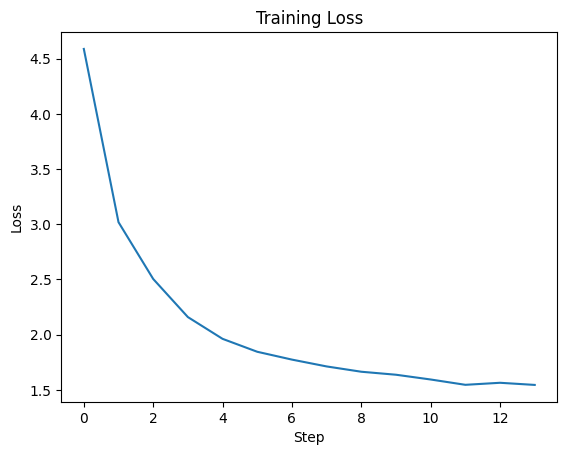

In [41]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

As you can see, the model goes from generating completely random words at the beginning to generating sensible tiny stories at the end of the training. So essentially we have pretrained a small LLM to write tiny stories for us.

## Saving
Save the model checkpoint.

In [42]:
import orbax.checkpoint as orbax

state = nnx.state(model)

checkpointer = orbax.PyTreeCheckpointer()
checkpointer.save('/content/save', state)

# Make sure the files are there
!ls /content/save/

_CHECKPOINT_METADATA  d  manifest.ocdbt  _METADATA  ocdbt.process_0  _sharding


## Profiling for Hyperparameter Tuning

In [ ]:
!pip install -Uq tensorboard-plugin-profile tensorflow tensorboard

Load the tensorboard colab extension.

In [ ]:
%load_ext tensorboard

As we're going to be running this model a number of times, we need some scaffolding to more easily compare our work. For a baseline, we'll need to perform some warmup to guarantee that our code is JIT'd and that our TPUs are warm. For improved comparability, we'll only start tracing after we've finished warmup.

In [ ]:
trace_dir = "/tmp/jax-trace/"

def loop_step(batch, step):
    input_batch = jnp.array(jnp.array(batch).T)
    target_batch = prep_target_batch(input_batch)
    train_step(model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

def generate_trace():
    tracing_steps = 30
    warmup_steps = 5
    for current_step in range(warmup_steps + tracing_steps):
        if current_step == warmup_steps:
            jax.profiler.start_trace(trace_dir)
        with jax.profiler.StepTraceAnnotation("train", step_num=current_step):
            batch = next(text_dl)
            loop_step(batch, current_step)

    jax.profiler.stop_trace()

Now we'll perform some traces to compare results of different batch sizes. This will take several minutes as we need to reprocess our input data to prepare new batches each time.

In [ ]:
trace_dir = "/tmp/jax-trace-batch-comparison/"

batch_size = 64
text_dl = iter(load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen))
generate_trace()

batch_size = 256
text_dl = iter(load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen))
generate_trace()

Run Tensorboard with the Profiler Plugin to compare our runs. Runs are listed in order from newest to oldest, so the top run in the list will be have `batch_size = 256`.

The key metrics to focus on here for this hyperparameter are FLOPS Utilization and Average Step Time.

In general, we want to maximize FLOPS Utilization while minimizing the step time per training example. In this case, we can see that increasing the batch size from 64 -> 256 achieves both of those. FLOPS increases from 16% to 27%. Average Step Time increase from 100ms to 260ms, however we increased our batch size by 300%. This means we move from 1.5ms per training example to 1.02ms per training example.

In [ ]:
%tensorboard --logdir=$trace_dir

Next, we can explore alternative parallelism methods. In cell #4, we used 4-way data parallel and 2-way tensor parallel. 8-way data parallel is another popular way. Let's compare results between them. To switch to 8-way data parallel, we'll replace the `Mesh` definition with:

`mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))`

JAX will automatically figure out how to shard the model and data to use the new partition strategy and nothing else need to be done. Re-connect the TPU runtime and run it again to see how it runs.

How simple and powerful is this! And that's the beauty of JAX automatic parallelism.

In [ ]:
trace_dir = "/tmp/jax-trace-parallelism-comparison/"

mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))
generate_trace()

mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))
generate_trace()

Once again we'll run tensorboard.

Looking at the results, we see that the step times are nearly the same, however the FLOPS Utilization is at 13% for 8-way data parallelism compared to 27% or 4-way data parallelism.

By looking at the Trace Viewer tool and looking under each TPU's ops, we can see that the TPUs spend a large amount of time idle while waiting for the host, as well as spending a good amount of time in `reduce_sum` operations.

In [ ]:
%tensorboard --logdir=$trace_dir

By changing hyperparameters and comparing profiles, we're able to gain significant insights into our bottlenecks and limitations. These are just two examples of hyperparameters to tune, but plenty more of them will have significant effects on training speed and resource utilization.

## Disconnect the Colab runtime

In [ ]:
from google.colab import runtime
runtime.unassign()